# Load key functions

In [1]:
# Enable autoreload to automatically update changes in modules
%load_ext autoreload
%autoreload 2

import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
from MySrc.general_utilities import load_nwb, get_units_tables, get_trial_timing, compute_average_firing_rate, fetch_key_metrices, check_quality, save_figure, load_selected_neurons # Import the function
from MySrc.plot_utilities import plot_neuron_general_metrices
import MySrc.dPCA_utilities
import numpy as np
from scipy.ndimage import gaussian_filter1d
from itertools import product


# load data and selected neurons

In [2]:
nwb_path = r"H:\My Drive\NWB_data_Monkey\Albus-S1_RightHand_psycho_NOpostchoice\exp2024-04-03-125141_prepro.nwb"
filtered_neuron_path = r"H:\My Drive\NWB_data_Monkey\NWB_Visualization\Albus-S1_RightHand_psycho_NOpostchoice\exp2024-04-03-125141_prepro\selected_neurons_LS1_good.json"


In [3]:
# Example usage (provide a valid file path)
session, selected_neurons = load_selected_neurons(filtered_neuron_path)
# If file was successfully loaded, print data
if session and selected_neurons is not None:
    print("📄 Loaded Data:", session, selected_neurons)

nwbfile, io = load_nwb(nwb_path)
# Get units table
units_tables, table_names = get_units_tables(nwbfile)

📂 Session Name: exp2024-04-03-125141_prepro
✅ Number of Selected Neurons: 21
📄 Loaded Data: exp2024-04-03-125141_prepro [['units-B1-129-160-14', 35], ['units-B1-129-160-14', 36], ['units-B1-129-160-15', 32], ['units-B1-129-160-15', 33], ['units-B1-129-160-15', 34], ['units-B1-129-160-15', 41], ['units-B1-129-160-16', 24], ['units-B1-129-160-16', 26], ['units-B1-129-160-16', 28], ['units-B1-129-160-16', 42], ['units-B1-129-160-17', 22], ['units-B1-129-160-18', 20], ['units-B1-129-160-18', 21], ['units-B1-129-160-20', 18], ['units-B1-129-160-23', 15], ['units-B1-129-160-24', 13], ['units-B1-129-160-24', 14], ['units-B1-129-160-28', 39], ['units-B1-129-160-29', 6], ['units-B1-129-160-29', 7], ['units-B1-129-160-32', 37]]


h:\My Drive\git_projects\NWB_visualization\venv\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


# Prototype: get trial x neurons x in-trial-time 3D tensor
given center event, obs window and smoothing parameters

prototype script for dPCA preprocessing: get trial x neuron x in-tirla time tensor

In [ ]:
# # Define parameters
# event = "stim1_ON_time"
# window_start, window_end = -1.0, 6.0  # Observation window (-1s to +6s)
# bin_size = 0.01  # 10ms bins
# time_bins = np.arange(window_start, window_end + bin_size, bin_size)  
# num_time_frames = len(time_bins) - 1  # Number of bins

# # ✅ Filter valid trials
# valid_trials_mask = nwbfile.trials["choiceTarget_ON_time"].data[:] > 0  # Ignore early-stopped trials that gives no choice target
# valid_event_times = nwbfile.trials[event].data[:][valid_trials_mask]
# num_trials = len(valid_event_times)

# # ✅ Initialize tensor (trials × neurons × time_bins)
# trial_tensor = np.zeros((num_trials, len(selected_neurons), num_time_frames))

# # Loop through neurons
# for neuron_idx, (electrode_name, unit_name) in enumerate(selected_neurons):
#     # Find correct electrode and unit
#     corrected_electrode_name = electrode_name.rsplit('-', 1)[0]
#     unit_table = units_tables[corrected_electrode_name]
#     true_unit_ids = unit_table.unit_name[:]

#     # Find unit index
#     index = np.where(true_unit_ids.astype(str) == str(unit_name))[0]
#     if index.size == 0:
#         print(f"⚠ Warning: unit {unit_name} not found in {corrected_electrode_name}, skipping.")
#         continue
#     index = index[0]

#     # Retrieve spike times
#     unit_spike_times = unit_table["spike_times"][index]

#     # Loop through valid trials
#     for trial_idx, event_time in enumerate(valid_event_times):
#         # Extract spikes within the window
#         spike_mask = (unit_spike_times >= event_time + window_start) & (unit_spike_times < event_time + window_end)
#         aligned_spikes = unit_spike_times[spike_mask] - event_time  # Align to event

#         # Compute spike histogram
#         spike_counts, _ = np.histogram(aligned_spikes, bins=time_bins)

#         # Apply Gaussian smoothing
#         sigma = 1  # Smoothing factor (adjust if needed)
#         spike_counts_smoothed = gaussian_filter1d(spike_counts.astype(float), sigma=sigma)
#         spike_counts_smoothed -= np.mean(spike_counts_smoothed)  # Normalize

#         # Store in tensor
#         trial_tensor[trial_idx, neuron_idx, :] = spike_counts_smoothed

# # Print final tensor shape
# print("Trial Tensor Shape:", trial_tensor.shape)  # Expected: (trials, neurons, time_bins)
# # Compute mean across all trials and time for each neuron (shape: (21, 1, 1))
# neuron_means = np.mean(trial_tensor, axis=(0, 2), keepdims=True)
# # Subtract mean from each neuron's activity
# normalized_trial_tensor = trial_tensor - neuron_means

Trial Tensor Shape: (80, 21, 700)


# Utility function: get trial x neurons x in-trial-time 3D tensor

In [4]:
from MySrc.dPCA_utilities import compute_TrNTi_tensor

# Define parameters
normalized_trial_tensor = compute_TrNTi_tensor(nwbfile, units_tables, selected_neurons, 
                         event="stim1_ON_time", window_start=-1.0, window_end=6.0, 
                         bin_size=0.01, normalize=True, gaussian_smooth=True, sigma=1)

Example unit 3's trial-averaging firing rate in defined window: sanity check

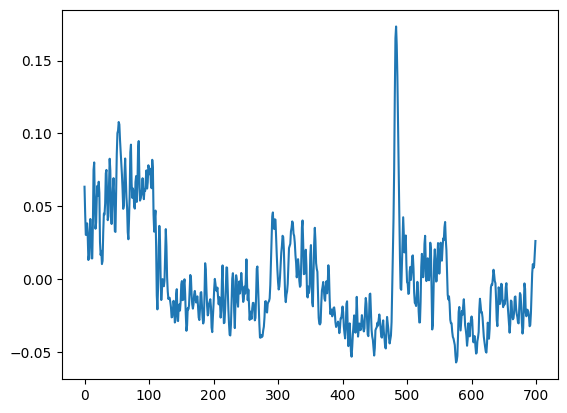

In [5]:
plt.plot(np.mean(normalized_trial_tensor[:,3,:], axis=0).T)

# Setup categorical axis/labels with same size as trial number and initialize multidimensional tensor for dPCA in shape:
neurons x in-trial-time x category1 x category2....etc, the example code is example, the categorical axis/labels  should be designed based on your researching goal

In [6]:
valid_trials_mask = nwbfile.trials["choiceTarget_ON_time"].data[:] > 0 
key_events = ["tact2_Left_AMP","tact2_Right_AMP","selectedChoiceTarget_ID","rewardStart_time"]
valid_event_times = {event: nwbfile.trials[event].data[:][valid_trials_mask] for event in key_events}

In [7]:
# ✅ Extract categorical labels based on the updated key events
# 1️⃣ **Hand of Stim** → Compare `tact1_Left_AMP` and `tact1_Right_AMP`
categories = {}
#categories["hand_of_stim"] = np.where(valid_event_times["tact1_Left_AMP"] > 0, 0, 1)
# 2️⃣ **Stim Strength** → Maximum of `tact2_Left_AMP` and `tact2_Right_AMP`
temp = np.maximum(valid_event_times["tact2_Left_AMP"], valid_event_times["tact2_Right_AMP"])
unique_values = np.sort(np.unique(temp))
# Create mapping from original values to discrete category indices (0 to num_classes-1)
value_to_category = {val: idx for idx, val in enumerate(unique_values)}

# Replace original values in the array with corresponding category indices
categories["stim_strength"] = np.vectorize(lambda x: value_to_category[x])(temp)
# ✅ Generate categories based on selectedChoiceTarget_ID
# 1️⃣ **High/Low Perception** → 1,2 means "low", 3,4 means "high"
categories["high_low"] = np.where(np.isin(valid_event_times["selectedChoiceTarget_ID"], [1, 2]), 0, 1)
# 2️⃣ **Left/Right Choice** → 1,3 means "left", 2,4 means "right"
categories["left_right"] = np.where(np.isin(valid_event_times["selectedChoiceTarget_ID"], [1, 3]), 0, 1)

#categories["reward"] = np.where((valid_event_times["rewardStart_time"]>0),1,0)


# Prototype: Based on combination of extracted categorical axis/labels:
calculate the mean of all trials of that category-combination into neurons x in-trial times "disc"
Then insert it to correct multidimentional tensor index based on its category-combination 

In [ ]:
# TrNTi_tensor = normalized_trial_tensor
# categories = categories

# category_names = list(categories.keys())
# print(category_names)
# category_sizes = [len(np.unique(categories[name])) for name in category_names]
# # Initialize the dPCA tensor with zeros
# dpca_tensor = np.zeros((TrNTi_tensor.shape[1], TrNTi_tensor.shape[2], *category_sizes))

# category_combinations = list(product(*[range(size) for size in category_sizes]))
# category_array = np.column_stack([categories[name] for name in category_names])
# # Fill the dPCA tensor by averaging trials for each category combination
# for combination in category_combinations:
#     # Find trials matching the current combination
#     mask = np.all(category_array == np.array(combination), axis=1)
#     matching_trials = normalized_trial_tensor[mask]  # Select trials

#     if matching_trials.shape[0] > 0:
#         # Compute mean over trials and insert into corresponding location
#         dpca_tensor[:, :, *combination] = np.mean(matching_trials, axis=0)
#     else:
#         print("no data found for this combination")
#         print(combination)

# # Return the constructed dPCA tensor
# dpca_tensor.shape  # Display the final shape for verification

# Utility function: Based on combination of extracted categorical axis/labels:

In [9]:
from MySrc.dPCA_utilities import compute_dpca_tensor
dpca_tensor, category_names = compute_dpca_tensor(normalized_trial_tensor, categories)

example: trial average FR for stratified condition: unit 3, animal sense strongest 2nd stem, and decide to choose high and gaze to left side

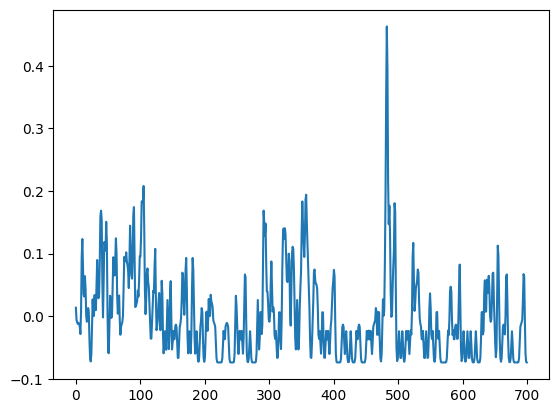

In [10]:
plt.plot(dpca_tensor[3,:,3,1,0])

# example of joining interested decoding elemets with its time modified version 
(my explanation is not optimal check https://github.com/machenslab/elife2016dpca as original authro's examples for paper)

In [11]:
from dPCA import dPCA
# ✅ Define dPCA model
join = {'stim_strenth' : ['s','ts'], 'decision' : ['d','td'], 'gaze_direction' : ['o','to'],'s_d_interplay' : ['sd','tsd'],
        'so':['so','tso'],'do':['do','tdo']}
dpca2 = dPCA.dPCA(labels='tsdo', join = join, regularizer=None, n_components=5)  # 5 categories
# ✅ Run dPCA on preprocessed matrix (Ensure correct shape: categories × (trials × time bins) × neurons)
Z2 = dpca2.fit_transform(dpca_tensor)

# ✅ Extract Components
explained_variance2 = dpca2.explained_variance_ratio_
#components = Z['1']  # 't' = time-related component


In [12]:
explained_variance2

{'t': [np.float64(0.03309993008825172),
  np.float64(0.01613271865016231),
  np.float64(0.006315021862507892),
  np.float64(0.005508536469588364),
  np.float64(0.0019626830551583464)],
 'sdo': [np.float64(1.4817788168264647e-64),
  np.float64(9.742283056327073e-65),
  np.float64(7.470850063332921e-65),
  np.float64(3.602888807614854e-65),
  np.float64(2.908511461247588e-65)],
 'tsdo': [np.float64(0.004039017862750205),
  np.float64(0.0029286826103415175),
  np.float64(0.002192691640791559),
  np.float64(0.001998439782560912),
  np.float64(0.0016120718210617586)],
 'stim_strenth': [np.float64(0.003490349793745562),
  np.float64(0.0029787561591175264),
  np.float64(0.0020732205296036094),
  np.float64(0.0016075877914237804),
  np.float64(0.0015502999231344313)],
 'decision': [np.float64(0.004558034841654977),
  np.float64(0.0006660658270960626),
  np.float64(0.0004830160233154988),
  np.float64(0.00040179859750899007),
  np.float64(0.00024232370387365315)],
 'gaze_direction': [np.float64

In [54]:
total_variance = np.var(TrNT_tensor)
print(total_variance)

0.019734126059246005


In [51]:
explained_variance2

{'t': [np.float64(0.033099892419076175),
  np.float64(0.01613238733746922),
  np.float64(0.006316925409592311),
  np.float64(0.0055096851221192195),
  np.float64(0.0019603618579277426)],
 'sdo': [np.float64(1.4826587229796393e-64),
  np.float64(9.743378667599408e-65),
  np.float64(7.483969390334419e-65),
  np.float64(3.6010505931701134e-65),
  np.float64(2.9051375710138478e-65)],
 'tsdo': [np.float64(0.004088524812280226),
  np.float64(0.0030066481934599046),
  np.float64(0.0020979339586917655),
  np.float64(0.0021022344216475998),
  np.float64(0.0015701033907509748)],
 'stim_strenth': [np.float64(0.0035117962819822576),
  np.float64(0.0030036807361126516),
  np.float64(0.002089075047548736),
  np.float64(0.0016365396895129754),
  np.float64(0.0014485837573097909)],
 'decision': [np.float64(0.004557644491192937),
  np.float64(0.0006639543422702166),
  np.float64(0.0004879119851786406),
  np.float64(0.0004079341439296372),
  np.float64(0.00024176896819140073)],
 'gaze_direction': [np.fl

In [274]:
from numpy.linalg import norm
A =  dpca.D["ts"][:,0]
B = dpca2.D["tr"][:,0]
cosine_similarity = np.dot(A, B) / (norm(A) * norm(B))  # Cosine similarity
angle = np.arccos(np.clip(cosine_similarity, -1.0, 1.0))
print(np.degrees(angle) )

45.195074218691026


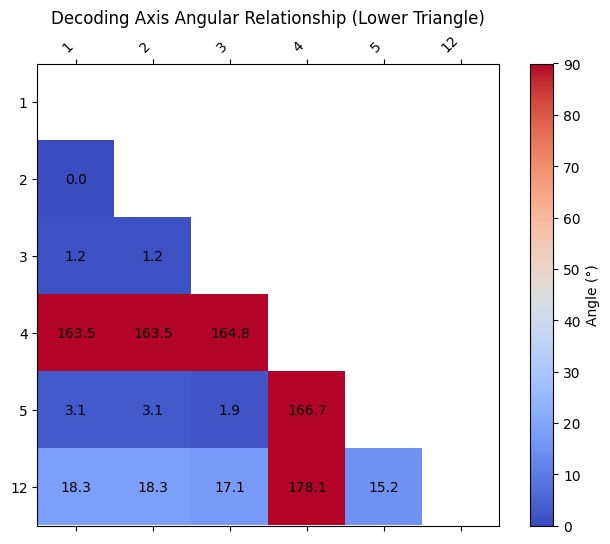

In [136]:
# Extract the first decoding axis for each category
decoding_axes = {event: dpca.D[event][:, 0] for event in ['1', '2', '3', '4', '5', '12']}
from numpy.linalg import norm
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

# Assume decoding_axes is available
categories = list(decoding_axes.keys())

# Compute angles between decoding axes
angles = {}
for (cat1, cat2) in combinations(categories, 2):
    A, B = decoding_axes[cat1], decoding_axes[cat2]
    cosine_similarity = np.dot(A, B) / (norm(A) * norm(B))  # Cosine similarity
    angle = np.arccos(np.clip(cosine_similarity, -1.0, 1.0))  # Ensure valid range
    angle_degrees = np.degrees(angle)  # Convert to degrees
    angles[(cat1, cat2)] = angle_degrees
    angles[(cat2, cat1)] = angle_degrees  # Ensure both orderings exist

# Create an empty matrix for angles
num_categories = len(categories)
angle_matrix = np.full((num_categories, num_categories), np.nan)  # Use NaN for masking upper triangle

# Fill lower triangle with computed angles
for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if j < i:  # Fill only lower triangle
            angle_matrix[i, j] = angles.get((cat1, cat2), np.nan)  # Use .get() to avoid KeyError

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(angle_matrix, cmap="coolwarm", vmin=0, vmax=90)  # Angle range limited to 90°
plt.colorbar(cax, label="Angle (°)")

# Set category labels
ax.set_xticks(np.arange(num_categories))
ax.set_yticks(np.arange(num_categories))
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.set_yticklabels(categories)

# Annotate matrix with angle values
for i in range(num_categories):
    for j in range(i):  # Only annotate lower triangle
        ax.text(j, i, f"{angle_matrix[i, j]:.1f}", ha="center", va="center", color="black")

# Title
plt.title("Decoding Axis Angular Relationship (Lower Triangle)")
plt.show()


In [96]:
decoding_axes = {event: Z[event].W[:, 0] for event in ['1', '2', '3', '4', '5', '12']}


AttributeError: 'numpy.ndarray' object has no attribute 'W'

In [ ]:
import numpy as np

# List of selected categories
categories = ['1', '2', '3', '4', '5', '12']

# Extract first principal component for each category
main_axes = {event: Z[event][0].flatten() for event in categories}  # Flatten to 1D
explained_variance

{'1': [np.float64(1.7198415471048898e-68),
  np.float64(1.689021263087618e-70),
  np.float64(5.756003874546423e-71),
  np.float64(1.151681364476056e-70),
  np.float64(1.7251914227283165e-102)],
 '2': [np.float64(1.7198415471048905e-68),
  np.float64(1.2970113861230566e-70),
  np.float64(1.259766986029505e-70),
  np.float64(8.595246428657506e-71),
  np.float64(6.370657076651397e-102)],
 '3': [np.float64(4.4081827250516706e-67),
  np.float64(3.7871062274553836e-69),
  np.float64(5.908914756656718e-69),
  np.float64(1.7567846959379996e-68),
  np.float64(2.2671580651004465e-71)],
 '4': [np.float64(3.340942899836183e-05),
  np.float64(1.4740863570410837e-37),
  np.float64(8.644631740983243e-38),
  np.float64(1.2156863769001613e-39),
  np.float64(3.527161462464605e-39)],
 '5': [np.float64(3.046633262609617e-68),
  np.float64(7.634826570177484e-70),
  np.float64(3.295190064429487e-70),
  np.float64(1.4660409896552109e-71),
  np.float64(8.928808199592526e-101)],
 '12': [np.float64(1.2619744824

In [ ]:
io.close